In [1]:
# Local imports
import os
import sys
import glob
import re

# Third party imports
import numpy as np
import xarray as xr
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
# Import dicionaries
sys.path.append('/home/users/benhutch/skill-maps')
import dicionaries as dic

# Import functions
import functions as func

# Import the NAO functions
from nao_skill_functions import nao_stats, \
                                plot_subplots_ind_models, plot_multi_model_mean, \
                                plot_multi_model_mean_spna, \
                                plot_subplots_ind_models_spna

# Import nao matching functions
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')
from nao_matching_seasons import match_variable_models, find_obs_path

# Import the bootstrapping functions
from process_bs_values import align_nao_matched_members, load_and_process_hist_data, \
                                extract_hist_models

### NAO/SPNA Matching ###

Testing whether:
1. Does NAO matching improve skill for the SPNA SSTs (tas in this case).
2. Does SPNA matching improve skill for the NAO anomalies

In the first case, we will consider whether NAO-matching improves the skill for SPNA SSTs. We want to create two subplots, one on the left showing the raw SPNA SST time series and the other (on the right) showing the NAO-matched SPNA SST time series. If NAO-matching improves the skill of the SPNA SST time series, this suggests that NAO may be a driver of predicability for the SPNA SSTs.

$\hat{F}_{SPNA} = \hat{F}_{NAO} + \hat{F}_{OTHER} + \hat{\epsilon}$

In the second case, we will consider whether SPNA SST matching improves the skill for NAO anomalies. By doing this we assume that some of the predicability for the NAO derives from SPNA SSTs, e.g.

$\hat{F}_{NAO} = \hat{F}_{SPNA} + \hat{F}_{OTHER} + \hat{\epsilon}$

In [3]:
# Set up the parameters
variable = "tas"
region = "global"
forecast_range = "2-9"
season = "DJFM"
start_year = 1960
end_year = 2022

# set up the base canari dir
canari_dir = "/gws/nopw/j04/canari/users/benhutch"

# Form the folder within which the data are stored
data_dir = os.path.join(canari_dir, "NAO-matching",
                        variable, region, season,
                        forecast_range, str(start_year) + "-" + str(end_year))

# Check if the data directory exists
if not os.path.exists(data_dir):
    raise ValueError("Data directory does not exist")

# Print the files stored in the data directory
print("Files in data directory:")
files = os.listdir(data_dir)

# Print the files
for file in files:
    print(file)

# Extract the file containing "members_lagged"
members_lagged_file = [file for file in files if "members_lagged" in file][0]

# Open the file
nao_matched_tas_members = xr.open_dataset(os.path.join(data_dir,
                                                        members_lagged_file))

Files in data directory:
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean_lagged.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members.nc
tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members_lagged.nc


In [4]:
# variable contained here is:
# '__xarray_dataarray_variable__'
nao_matched_tas_members

<xarray.Dataset>
Dimensions:                        (time: 50, member: 20, lat: 72, lon: 144)
Coordinates:
  * time                           (time) int64 1969 1970 1971 ... 2017 2018
  * member                         (member) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * lat                            (lat) float64 -90.0 -87.5 -85.0 ... 85.0 87.5
  * lon                            (lon) float64 -180.0 -177.5 ... 175.0 177.5
Data variables:
    __xarray_dataarray_variable__  (time, member, lat, lon) float64 ...

In [5]:
# Extract the observations
obs_tas_anom = func.read_obs(variable=variable,
                             region=region,
                             forecast_range=forecast_range,
                             season=season,
                             observations_path=dic.obs,
                             start_year=start_year,
                             end_year=end_year)

Time dimension of obs: ['1960-12-31T00:00:00.000000000' '1961-12-31T00:00:00.000000000'
 '1962-12-31T00:00:00.000000000' '1963-12-31T00:00:00.000000000'
 '1964-12-31T00:00:00.000000000' '1965-12-31T00:00:00.000000000'
 '1966-12-31T00:00:00.000000000' '1967-12-31T00:00:00.000000000'
 '1968-12-31T00:00:00.000000000' '1969-12-31T00:00:00.000000000'
 '1970-12-31T00:00:00.000000000' '1971-12-31T00:00:00.000000000'
 '1972-12-31T00:00:00.000000000' '1973-12-31T00:00:00.000000000'
 '1974-12-31T00:00:00.000000000' '1975-12-31T00:00:00.000000000'
 '1976-12-31T00:00:00.000000000' '1977-12-31T00:00:00.000000000'
 '1978-12-31T00:00:00.000000000' '1979-12-31T00:00:00.000000000'
 '1980-12-31T00:00:00.000000000' '1981-12-31T00:00:00.000000000'
 '1982-12-31T00:00:00.000000000' '1983-12-31T00:00:00.000000000'
 '1984-12-31T00:00:00.000000000' '1985-12-31T00:00:00.000000000'
 '1986-12-31T00:00:00.000000000' '1987-12-31T00:00:00.000000000'
 '1988-12-31T00:00:00.000000000' '1989-12-31T00:00:00.000000000'
 '

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/iris/coords.py:2220: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


In [6]:
# Load and process historical data first (for the align function)
hist_data = load_and_process_hist_data(base_dir="/home/users/benhutch/skill-maps-processed-data/historical",
                                       hist_models=extract_hist_models(variable, dic),
                                       variable=variable,
                                       region=region,
                                       forecast_range=forecast_range,
                                       season=season)

# Constrain the historical data to the same time period as the observations
constrained_hist_data = func.constrain_years(hist_data,
                                             extract_hist_models(variable, dic))

processing model:  BCC-CSM2-MR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/BCC-CSM2-MR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  MPI-ESM1-2-HR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/MPI-ESM1-2-HR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CanESM5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CanESM5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CMCC-CM2-SR5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CMCC-CM2-SR5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  HadGEM3-GC31-MM
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/HadGEM3-GC31-MM/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  MPI-ESM1-2-LR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/MPI-ESM1-2-LR/global/years_2-9/DJFM/outputs/processed/*.nc
processing m

In [7]:
# Align the members using the function
aligned_data = align_nao_matched_members(obs=obs_tas_anom,
                                         nao_matched_members=nao_matched_tas_members,
                                         constrained_hist_data=constrained_hist_data,
                                         hist_models=extract_hist_models(variable, dic))

there are NaN values in the observations for 1960
all values are NaN for 1960
there are NaN values in the observations for 1961
all values are NaN for 1961
there are NaN values in the observations for 1962
all values are NaN for 1962
there are NaN values in the observations for 1963
all values are NaN for 1963
there are no NaN values in the observations for 1964
there are no NaN values in the observations for 1965
there are no NaN values in the observations for 1966
there are no NaN values in the observations for 1967
there are no NaN values in the observations for 1968
there are no NaN values in the observations for 1969
there are no NaN values in the observations for 1970
there are no NaN values in the observations for 1971
there are no NaN values in the observations for 1972
there are no NaN values in the observations for 1973
there are no NaN values in the observations for 1974
there are no NaN values in the observations for 1975
there are no NaN values in the observations for 1976

In [14]:
# Import importlib
import importlib

# Reload the dicionaries
importlib.reload(sys.modules['dicionaries'])

# Reload the functions
importlib.reload(sys.modules['functions'])

# Reload the nao functions
importlib.reload(sys.modules['nao_skill_functions'])

# Reload the nao matching functions
importlib.reload(sys.modules['nao_matching_seasons'])

# Reload the bootstrapping functions
importlib.reload(sys.modules['process_bs_values'])

# Import the dicionaries
import dicionaries as dic

# Import the functions
import functions as func

# Import the nao functions
from nao_skill_functions import nao_stats, \
                                plot_subplots_ind_models, plot_multi_model_mean, \
                                plot_multi_model_mean_spna, \
                                plot_subplots_ind_models_spna

# Import nao matching functions
sys.path.append('/home/users/benhutch/skill-maps/rose-suite-matching')
from nao_matching_seasons import match_variable_models, find_obs_path

# Import the bootstrapping functions
from process_bs_values import align_nao_matched_members, load_and_process_hist_data, \
                                extract_hist_models

In [15]:
# extract the data from the aligned data
nao_matched_tas_members_array = aligned_data[0]
obs_tas_anom = aligned_data[2]
common_years = aligned_data[3]

# Print the shape of the data
print(nao_matched_tas_members_array.shape)
print(obs_tas_anom.shape)
print(common_years.shape)
print(common_years)

(20, 43, 72, 144)
(43, 72, 144)
(43,)
[1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011]


In [35]:
# We want to find the indexes for lat and lon
# which correspond to the SPNA region for the regridded data
lats = nao_matched_tas_members.lat.values
lons = nao_matched_tas_members.lon.values

# Print the lats and lons
print(lats)
print(lons)

# Extract the lats and lons for the SPNA region
lat1, lat2 = dic.spna_grid_strommen['lat1'], dic.spna_grid_strommen['lat2']
lon1, lon2 = dic.spna_grid_strommen['lon1'], dic.spna_grid_strommen['lon2']

# Print the lats and lons
print(lat1, lat2)
print(lon1, lon2)

# Find the indexes for the lat and lon
# Find the values closest to the lat and lon
lat1_idx = np.argmin(np.abs(lats - lat1))
lat2_idx = np.argmin(np.abs(lats - lat2))
lon1_idx = np.argmin(np.abs(lons - lon1))
lon2_idx = np.argmin(np.abs(lons - lon2))

# Print the indexes
print(lat1_idx, lat2_idx, lon1_idx, lon2_idx)

# Constrain the lats and lons to the SPNA region
lats_spna = lats[lat1_idx:lat2_idx + 1]
lons_spna = lons[lon1_idx:lon2_idx + 1]

# Print the lats and lons
print(lats_spna)
print(lons_spna)

TypeError: '.dt' accessor only available for DataArray with datetime64 timedelta64 dtype or for arrays containing cftime datetime objects.

In [24]:
# Collapse the nao_matched and obs data to the SPNA region
# Constrain to the region
# and take the mean over the lat and lon axes
nao_matched_tas_members_spna = nao_matched_tas_members_array[:, :,
                                                            lat1_idx:lat2_idx + 1,
                                                            lon1_idx:lon2_idx + 1].mean(axis=(2, 3))

# Print the shape of the data
print(nao_matched_tas_members_spna.shape)

# Collapse the obs data to the SPNA region
# Constrain to the region
# and take the mean over the lat and lon axes
obs_tas_anom_spna = obs_tas_anom[:, lat1_idx:lat2_idx + 1,
                                 lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# Print the shape of the data
print(obs_tas_anom_spna.shape)

(20, 43)
(43,)


In [40]:
# Also import the raw data for comparison
raw_dir = "/gws/nopw/j04/canari/users/benhutch/bootstrapping/tas/global/DJFM/2-9/raw/no_bootstraps_1"

# find the files containing "ts" in this directory
files = os.listdir(raw_dir)

# # Print the files
# for file in files:
#     print(file)

# Extract the file containing "ts"
ts_file = [file for file in files if "fcst1_ts" in file][0]

# Extract the file containing "obs_ts"
obs_ts_file = [file for file in files if "obs_ts" in file][0]

# Extract the years from the file name
years_file = [file for file in files if "years" in file][0]

# find the file containing nens1_tas
nens1_tas_file = [file for file in files if "nens1_tas" in file][0]

# Open the file
print(ts_file)

# Open the file
print(obs_ts_file)

# print what is contained within the nens1_tas .txt file
with open(os.path.join(raw_dir, nens1_tas_file), 'r') as f:
    print(f.read())

# Print what is contained within the years .txt file
# with open(os.path.join(raw_dir, years_file), 'r') as f:
#     print(f.read())
# 1966 to 2011
# generate an array of years
years = np.arange(1966, 2012)

# print the length of the years
print(len(years))

# How can I select the inidcies from 1969 to 2011?
# I can use np.where
# Find the indices for the years
start_year_nm = 1969
end_year_nm = 2011

# Find the indices for the years
start_idx = np.where(years == start_year_nm)[0][0]
end_idx = np.where(years == end_year_nm)[0][0]

# Print the indices
print(start_idx, end_idx)
print(years[start_idx], years[end_idx])

# Open these .npy files
fcst1_ts = np.load(os.path.join(raw_dir, ts_file))
obs_ts = np.load(os.path.join(raw_dir, obs_ts_file))

# Print the shape of the data
print(fcst1_ts.shape)
print(obs_ts.shape)

# Extract the data for the SPNA region
fcst1_ts_spna = fcst1_ts[start_idx:, lat1_idx:lat2_idx + 1,
                         lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# extract the obs data for the SPNA region
obs_ts_spna = obs_ts[start_idx:, lat1_idx:lat2_idx + 1,
                     lon1_idx:lon2_idx + 1].mean(axis=(1, 2))

# Print the shape of the data
print(fcst1_ts_spna.shape)
print(obs_ts_spna.shape)

fcst1_ts_tas_global_DJFM_2-9.npy
obs_ts_tas_global_DJFM_2-9.npy
1.600000000000000000e+02

46
3 45
1969 2011
(46, 72, 144)
(46, 72, 144)
(43,)
(43,)


### NAO-matched SPNA time series ###

* Subplot with raw on the left and nao-matched on the right

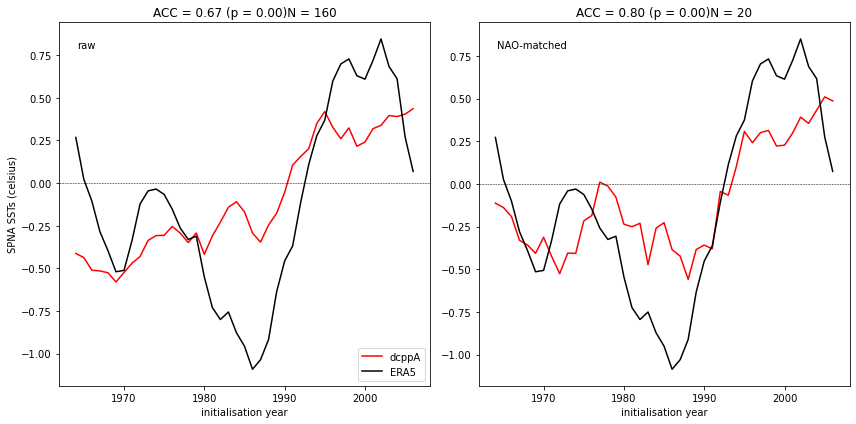

In [44]:
# Set up the figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Set up the no. ensemble members
nao_match_nens = 20
raw_nens = 160 # approx - some may be missing

# take the mean over the 0th axis for the nao matched data
nao_match_mean = nao_matched_tas_members_spna.mean(axis=0)

# Calculate the correlation coefficient for the raw
corr_raw, p_raw = pearsonr(fcst1_ts_spna, obs_ts_spna)

# Calculate the correlation coefficient for the nao matched
corr_nm, p_nm = pearsonr(nao_match_mean, obs_tas_anom_spna)

# Can't calculate RPC as don't have all members for the raw data

# Set up the axes
ax1 = ax[0] ; ax2 = ax[1]

# Plot the ensemble mean for the raw data
ax1.plot(years[start_idx:] - 5, fcst1_ts_spna, color='red', label='dcppA')

# Plot the observed data
ax1.plot(years[start_idx:] - 5, obs_ts_spna, color='black', label='ERA5')

# Set up the titles
ax1.set_title(f"ACC = {corr_raw:.2f} (p = {p_raw:.2f})"
              f"N = {raw_nens}")

# Format a textbox containing raw in the top left corner
ax1.text(0.05, 0.95, 'raw', transform=ax1.transAxes,
         ha="left", va="top",
            fontsize=10)

# Plot the ensemble mean for the nao matched data
ax2.plot(years[start_idx:] - 5, nao_match_mean, color='red', label='dcppA')

# Plot the observed data
ax2.plot(years[start_idx:] - 5, obs_tas_anom_spna, color='black', label='ERA5')

# Set up the titles
ax2.set_title(f"ACC = {corr_nm:.2f} (p = {p_nm:.2f})"
              f"N = {nao_match_nens}")

# Format a textbox containing nao matched in the top left corner
ax2.text(0.05, 0.95, 'NAO-matched', transform=ax2.transAxes,
            ha="left", va="top",
                fontsize=10)

# Set up the legend
ax1.legend(loc='lower right', fontsize=10)

# Set up zero lines
ax1.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Set the y-axis label for the left column
ax1.set_ylabel("SPNA SSTs (celsius)")

# Set a common x-axis label
ax1.set_xlabel("initialisation year")
ax2.set_xlabel("initialisation year")

# Specify the tight layout
plt.tight_layout()

# Show the plot
plt.show()